# PINN: Physics-Informed Neural Network

## Solve
$$ \epsilon \frac{d^2u(x)}{dx^2} + (1+x) \frac{du(x)}{dx} + u(x) = 0 $$
$f(x)$: Given function  
$u(0)=u(1)=1$: Given boundary condition  
$\epsilon=0.01$: Given small constant parameter  


### PINNにおけるニューラルネットワーク構造の工夫
- ニューラルネットワークは、適切な条件の下で任意の連続関数を近似可能な表現力を持つ（普遍近似定理）。しかしあくまでこれは近似可能性を保証しているだけで、最適なニューラルネットワークが実現できるか、学習が効率的に進むかは別問題。
- このノートブックでは、解に異なる長さスケールが現れる境界層問題を例に、ニューラルネットワーク構造の工夫により、学習効率が劇的に変わり得ることを示す。

Step    0:  Regular loss = 2.30e+00,  Regular(BC) loss = 1.00e+00,  Matched loss = 6.50e+00,  Matched(AT) loss = 6.50e+00
Step  100:  Regular loss = 1.75e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 8.78e-01,  Matched(AT) loss = 8.78e-01
Step  200:  Regular loss = 1.72e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 2.19e-01,  Matched(AT) loss = 2.19e-01
Step  300:  Regular loss = 1.71e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 3.85e-02,  Matched(AT) loss = 3.85e-02
Step  400:  Regular loss = 1.69e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 7.66e-03,  Matched(AT) loss = 7.66e-03
Step  500:  Regular loss = 1.67e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 3.29e-03,  Matched(AT) loss = 3.29e-03
Step  600:  Regular loss = 1.67e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 2.01e-03,  Matched(AT) loss = 2.01e-03
Step  700:  Regular loss = 1.67e-01,  Regular(BC) loss = 1.00e+00,  Matched loss = 1.30e-03,  Matched(AT) loss = 1.30e-03
Step  800:  Regular loss

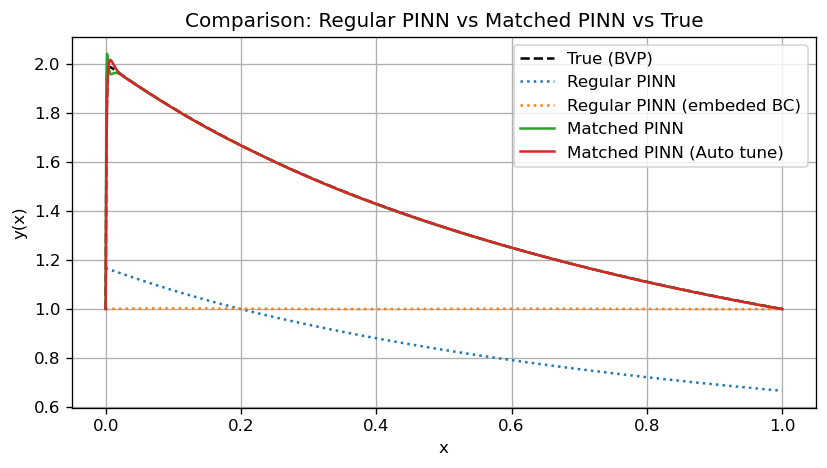

In [4]:
# --- ライブラリ読み込み ---
import jax
import jax.numpy as jnp
import optax
import functools
from flax import linen as nn
import numpy as np
import matplotlib.pyplot as plt
from jax import vmap
from scipy.integrate import solve_bvp

# --- 問題パラメータ ---
epsilon = 0.001
epsilon_sqrt = float(jnp.sqrt(epsilon))

# --- 通常のMLP（Regular PINN用）---
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for width in self.layers[:-1]:
            x = nn.tanh(nn.Dense(width)(x))
        return nn.Dense(self.layers[-1])(x)

# --- Regular PINN構造：境界条件組込み ---
class BC_MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        x_in = x
        for width in self.layers[:-1]:
            x = nn.tanh(nn.Dense(width)(x))
        x = nn.Dense(self.layers[-1])(x)
        return (1 - x_in) * x_in * x + 1.0

# --- Asymptotically Matched PINN ---
class MatchedMLP(nn.Module):
    in_layers: list
    out_layers: list
    delta: float = 0.01
    width: float = 0.05
    center: float = 0.1

    def setup(self):
        self.model_in = MLP(self.in_layers)
        self.model_out = MLP(self.out_layers)

    def smooth_mask(self, x):
        return 0.5 * (1.0 + jnp.tanh((self.center - x) / self.width))

    def __call__(self, x):
        xi = x / self.delta
        y_in = self.model_in(xi)
        y_out = self.model_out(x)
        w = self.smooth_mask(x)
        return w * y_in + (1 - w) * y_out

# --- Asymptotically Matched PINN with automatic tune ---
class MatchedMLP_autotune(nn.Module):
    in_layers: list
    out_layers: list
    init_delta: float = 0.01

    def setup(self):
        sqrt_delta = jnp.sqrt(self.init_delta)

        # 学習可能パラメータとして登録（初期値は想定通り）
        self.delta = self.param("delta", lambda key: self.init_delta)
        self.width = self.param("width", lambda key: sqrt_delta)
        self.center = self.param("center", lambda key: 5.0 * sqrt_delta)

        self.model_in = MLP(self.in_layers)
        self.model_out = MLP(self.out_layers)

    def smooth_mask(self, x):
        return 0.5 * (1.0 - jnp.tanh((x - self.center) / self.width))

    def __call__(self, x):
        xi = x / self.delta
        y_in = self.model_in(xi)
        y_out = self.model_out(x)
        w = self.smooth_mask(x)
        return w * y_in + (1 - w) * y_out


# --- 残差定義 ---
def residual(model, params, x):
    def u_scalar(xi):
        return model.apply(params, jnp.array([[xi]])).flatten()[0]
    u1 = jax.grad(u_scalar)
    u2 = jax.grad(u1)
    # vmapで一括計算
    return epsilon * vmap(u2)(x) + (1 + x) * vmap(u1)(x) + model.apply(params, x.reshape(-1,1)).flatten()

# --- ロス関数 ---
def loss_fn(params, model, x_col, x_bc):
    res = residual(model, params, x_col)
    y0 = model.apply(params, jnp.array([[x_bc[0]]])).flatten()[0]
    y1 = model.apply(params, jnp.array([[x_bc[1]]])).flatten()[0]
    bc_loss = (y0 - 1.0)**2 + (y1 - 1.0)**2
    return jnp.mean(res**2) + bc_loss

# --- 訓練点 ---
# x_col = jnp.linspace(0, 1, 100)
from scipy.stats.qmc import Sobol
sampler = Sobol(d=1, scramble=True)
x_col = sampler.random_base2(m=6).flatten()  # 2^6 = 64点
x_col = jnp.array(x_col)
x_bc = jnp.array([0.0, 1.0])

# --- モデル初期化 ---
model_reg = MLP([64, 64, 1])
params_reg = model_reg.init(jax.random.PRNGKey(0), x_col.reshape(-1,1))

model_regbc = BC_MLP([64, 64, 1])
params_regbc = model_regbc.init(jax.random.PRNGKey(0), x_col.reshape(-1,1))

model_matched = MatchedMLP([32, 32, 1], [32, 32, 1], delta=epsilon)
params_matched = model_matched.init(jax.random.PRNGKey(1), x_col.reshape(-1,1))

model_matched_at = MatchedMLP_autotune([32, 32, 1], [32, 32, 1], init_delta=epsilon)
params_matched_at = model_matched_at.init(jax.random.PRNGKey(1), x_col.reshape(-1,1))

# --- オプティマイザ ---
opt = optax.adam(1e-3)
opt_state_reg = opt.init(params_reg)
opt_state_regbc = opt.init(params_regbc)
opt_state_matched = opt.init(params_matched)
opt_state_matched_at = opt.init(params_matched_at)

# === 学習ステップの定義 ===
# モデルと訓練点をクロージャで固定し、jitの引数に渡さないようにする
def make_train_step(model, x_col, x_bc):
    @jax.jit
    def train_step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params, model, x_col, x_bc)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    return train_step

train_step_reg = make_train_step(model_reg, x_col, x_bc)
train_step_regbc = make_train_step(model_regbc, x_col, x_bc)
train_step_matched = make_train_step(model_matched, x_col, x_bc)
train_step_matched_at = make_train_step(model_matched_at, x_col, x_bc)

# --- 学習ループ ---
for step in range(1001):
    params_reg, opt_state_reg, loss_r = train_step_reg(params_reg, opt_state_reg)
    params_regbc, opt_state_regbc, loss_rbc = train_step_regbc(params_regbc, opt_state_regbc)
    params_matched, opt_state_matched, loss_m = train_step_matched(params_matched, opt_state_matched)
    params_matched_at, opt_state_matched_at, loss_m = train_step_matched_at(params_matched_at, opt_state_matched_at)
    if step % 100 == 0:
        print(f"Step {step:>4}:  Regular loss = {loss_r:.2e},  Regular(BC) loss = {loss_rbc:.2e},  Matched loss = {loss_m:.2e},  Matched(AT) loss = {loss_m:.2e}")

# --- 解の計算 ---
x = jnp.linspace(0, 1, 1000)
y_reg = model_reg.apply(params_reg, x.reshape(-1,1)).flatten()
y_regbc = model_regbc.apply(params_regbc, x.reshape(-1,1)).flatten()
y_matched = model_matched.apply(params_matched, x.reshape(-1,1)).flatten()
y_matched_at = model_matched_at.apply(params_matched_at, x.reshape(-1,1)).flatten()

# --- 解析解（scipy.solve_bvp） ---
x_np = np.linspace(0, 1, 1000)
y_init = np.ones((2, x_np.size))

def bvp_func(x, y):
    dydx = y[1]
    d2ydx2 = (-(1 + x) * y[1] - y[0]) / epsilon
    return np.vstack((dydx, d2ydx2))

def bc(ya, yb):
    return np.array([ya[0] - 1.0, yb[0] - 1.0])

sol = solve_bvp(bvp_func, bc, x_np, y_init)
y_true = sol.sol(x_np)[0]

# --- 可視化 ---
plt.figure(figsize=(7,4), dpi=120)
plt.plot(x_np, y_true, '--k', label="True (BVP)")
plt.plot(x, y_reg, ':', label="Regular PINN")
plt.plot(x, y_regbc, ':', label="Regular PINN (embeded BC)")
plt.plot(x, y_matched, '-', label="Matched PINN")
plt.plot(x, y_matched_at, '-', label="Matched PINN (Auto tune)")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Comparison: Regular PINN vs Matched PINN vs True")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

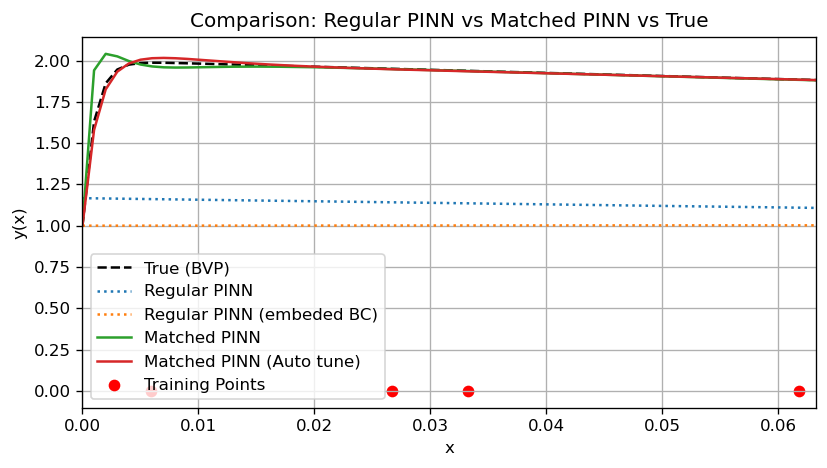

In [5]:
# --- 可視化 ---
plt.figure(figsize=(7,4), dpi=120)
plt.plot(x_np, y_true, '--k', label="True (BVP)")
plt.plot(x, y_reg, ':', label="Regular PINN")
plt.plot(x, y_regbc, ':', label="Regular PINN (embeded BC)")
plt.plot(x, y_matched, '-', label="Matched PINN")
plt.plot(x, y_matched_at, '-', label="Matched PINN (Auto tune)")
plt.scatter(x_col, np.zeros_like(x_col), color="red", label="Training Points")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.xlim(0,2*epsilon_sqrt)
plt.title("Comparison: Regular PINN vs Matched PINN vs True")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
print(params_matched["params"]["center"], epsilon_sqrt*5)
print(params_matched["params"]["width"], epsilon_sqrt)
print(params_matched["params"]["delta"], epsilon)

KeyError: 'center'

In [ ]:
# --- ライブラリ読み込み ---
import jax
import jax.numpy as jnp
import optax
import functools
from flax import linen as nn
import numpy as np
import matplotlib.pyplot as plt
from jax import vmap
from scipy.integrate import solve_bvp

# --- 問題パラメータ ---
epsilon = 0.01
epsilon_sqrt = float(jnp.sqrt(epsilon))

# --- 通常のMLP（Regular PINN用）---
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for width in self.layers[:-1]:
            x = nn.tanh(nn.Dense(width)(x))
        return nn.Dense(self.layers[-1])(x)

# --- Regular PINN構造：境界条件組込み ---
class BC_MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        x_in = x
        for width in self.layers[:-1]:
            x = nn.tanh(nn.Dense(width)(x))
        x = nn.Dense(self.layers[-1])(x)
        return (1 - x_in) * x_in * x + 1.0

# --- Asymptotically Matched PINN ---
class MatchedMLP(nn.Module):
    in_layers: list
    out_layers: list
    delta: float = 0.01
    width: float = 0.05
    center: float = 0.1

    def setup(self):
        self.model_in = MLP(self.in_layers)
        self.model_out = MLP(self.out_layers)

    def smooth_mask(self, x):
        return 0.5 * (1.0 + jnp.tanh((self.center - x) / self.width))

    def __call__(self, x):
        xi = x / self.delta
        y_in = self.model_in(xi)
        y_out = self.model_out(x)
        w = self.smooth_mask(x)
        return w * y_in + (1 - w) * y_out

# --- Asymptotically Matched PINN with automatic tune ---
class MatchedMLP_autotune(nn.Module):
    in_layers: list
    out_layers: list
    init_delta: float = 0.01

    def setup(self):
        sqrt_delta = jnp.sqrt(self.init_delta)

        # 学習可能パラメータとして登録（初期値は想定通り）
        self.delta = self.param("delta", lambda key: self.init_delta)
        self.width = self.param("width", lambda key: sqrt_delta)
        self.center = self.param("center", lambda key: 5.0 * sqrt_delta)

        self.model_in = MLP(self.in_layers)
        self.model_out = MLP(self.out_layers)

    def smooth_mask(self, x):
        return 0.5 * (1.0 - jnp.tanh((x - self.center) / self.width))

    def __call__(self, x):
        xi = x / self.delta
        y_in = self.model_in(xi)
        y_out = self.model_out(x)
        w = self.smooth_mask(x)
        return w * y_in + (1 - w) * y_out


# --- 残差定義 ---
def residual(model, params, x):
    def u_scalar(xi):
        return model.apply(params, jnp.array([[xi]])).flatten()[0]
    u1 = jax.grad(u_scalar)
    u2 = jax.grad(u1)
    # vmapで一括計算
    return epsilon * vmap(u2)(x) + (1 + x) * vmap(u1)(x) + model.apply(params, x.reshape(-1,1)).flatten()

# --- ロス関数 ---
def loss_fn(params, model, x_col, x_bc, y_bc):
    res = residual(model, params, x_col)
    bc_loss = jnp.sum((model.apply(params, x_bc.reshape(-1,1)).flatten() - y_bc)**2)
    return jnp.mean(res**2) + bc_loss

# --- 訓練点 ---
# x_col = jnp.linspace(0, 1, 100)
from scipy.stats.qmc import Sobol
sampler = Sobol(d=1, scramble=True)
x_col = sampler.random_base2(m=6).flatten()  # 2^6 = 64点
x_col = jnp.array(x_col)
x_bc = jnp.array([0.0, 1.0])
y_bc = jnp.array([0.0, 1.0])

# --- モデル初期化 ---
model_reg = MLP([64, 64, 1])
params_reg = model_reg.init(jax.random.PRNGKey(0), x_col.reshape(-1,1))

model_regbc = BC_MLP([64, 64, 1])
params_regbc = model_regbc.init(jax.random.PRNGKey(0), x_col.reshape(-1,1))

model_matched = MatchedMLP([32, 32, 1], [32, 32, 1], delta=epsilon)
params_matched = model_matched.init(jax.random.PRNGKey(1), x_col.reshape(-1,1))

model_matched_at = MatchedMLP_autotune([32, 32, 1], [32, 32, 1], init_delta=epsilon)
params_matched_at = model_matched_at.init(jax.random.PRNGKey(1), x_col.reshape(-1,1))

# --- オプティマイザ ---
opt = optax.adam(1e-3)
opt_state_reg = opt.init(params_reg)
opt_state_regbc = opt.init(params_regbc)
opt_state_matched = opt.init(params_matched)
opt_state_matched_at = opt.init(params_matched_at)

# === 学習ステップの定義 ===
# モデルと訓練点をクロージャで固定し、jitの引数に渡さないようにする
def make_train_step(model, x_col, x_bc, y_bc):
    @jax.jit
    def train_step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params, model, x_col, x_bc, y_bc)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    return train_step

train_step_reg = make_train_step(model_reg, x_col, x_bc, y_bc)
train_step_regbc = make_train_step(model_regbc, x_col, x_bc, y_bc)
train_step_matched = make_train_step(model_matched, x_col, x_bc, y_bc)
train_step_matched_at = make_train_step(model_matched_at, x_col, x_bc, y_bc)

# --- 学習ループ ---
for step in range(1001):
    params_reg, opt_state_reg, loss_r = train_step_reg(params_reg, opt_state_reg)
    params_regbc, opt_state_regbc, loss_rbc = train_step_regbc(params_regbc, opt_state_regbc)
    params_matched, opt_state_matched, loss_m = train_step_matched(params_matched, opt_state_matched)
    params_matched_at, opt_state_matched_at, loss_m = train_step_matched_at(params_matched_at, opt_state_matched_at)
    if step % 100 == 0:
        print(f"Step {step:>4}:  Regular loss = {loss_r:.2e},  Regular(BC) loss = {loss_rbc:.2e},  Matched loss = {loss_m:.2e},  Matched(AT) loss = {loss_m:.2e}")

# --- 解の計算 ---
x = jnp.linspace(0, 1, 1000)
y_reg = model_reg.apply(params_reg, x.reshape(-1,1)).flatten()
y_regbc = model_regbc.apply(params_regbc, x.reshape(-1,1)).flatten()
y_matched = model_matched.apply(params_matched, x.reshape(-1,1)).flatten()
y_matched_at = model_matched_at.apply(params_matched_at, x.reshape(-1,1)).flatten()

# --- 解析解（scipy.solve_bvp） ---
x_np = np.linspace(0, 1, 1000)
y_init = np.ones((2, x_np.size))

def bvp_func(x, y):
    dydx = y[1]
    d2ydx2 = (-(1 + x) * y[1] - y[0]) / epsilon
    return np.vstack((dydx, d2ydx2))

def bc(ya, yb):
    return np.array([ya[0] - y_bc[0], yb[0] - y_bc[1]])
print(y_bc[0], y_bc[1])
sol = solve_bvp(bvp_func, bc, x_np, y_init)
y_true = sol.sol(x_np)[0]

# --- 可視化 ---
plt.figure(figsize=(7,4), dpi=120)
plt.plot(x_np, y_true, '--k', label="True (BVP)")
plt.plot(x, y_reg, ':', label="Regular PINN")
plt.plot(x, y_regbc, ':', label="Regular PINN (embeded BC)")
plt.plot(x, y_matched, '-', label="Matched PINN")
plt.plot(x, y_matched_at, '-', label="Matched PINN (Auto tune)")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Comparison: Regular PINN vs Matched PINN vs True")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()